# Computing bilateral travel times matrices from Shapefiles
Some parts of the code below were heavily inspired/created by Kalle Kappner code adapted by Andrea Herrera in 03/2024 for the course "Quantitative Spatial Economics" dictated by Professor Gabriel Ahlfeldt at Humboldt-Universität zu Berlin.  

# 0. Loading packages, setting root directories

In [4]:
# !pip install pandas
# !pip install geopandas
# !pip install shapely
# !pip install networkx
# !pip install matplotlib
# !pip install numpy

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point

In [6]:
root_path = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/shape/"
data_input_path = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/data/input/"
root_fig_path = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/python/"

## 0. Define helper function extracting chosen values from "other_tags" tag to separate columns

In [46]:
def prepare_shapefile(shapefile_path, extracted_tags = []):
    """
    This function reads a shapefile into a GeoDataFrame and extracts specific tags from the "other_tags" 
    column, adding them as new columns in the GeoDataFrame. For each tag in the extracted_tags list, 
    a new column is created. If the tag is found in the "other_tags" dictionary for a given row, 
    its value is added to the corresponding column. Otherwise, the column remains None.

    Parameters:
    shapefile_path (str): The path to the shapefile.
    extracted_tags (list of str): A list of tags to extract from the "other_tags" column.

    Returns:
    GeoDataFrame: A GeoDataFrame with the new columns added for each extracted tag.
    """
    
    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    # Iterate over each tag in the extracted_tags list
    for tag in extracted_tags:
        # Create a new column for each tag in the extracted_tags list
        gdf[tag] = None

        skipped_tags = 0

        # Iterate over the rows of the GeoDataFrame
        for index, row in gdf.iterrows():
            # Check if the "other_tags" column is not empty
            if pd.notna(row['other_tags']):
                try:
                    # Convert the "other_tags" string to a dictionary
                    other_tags_dict = {}
                    for item in row['other_tags'].replace('","', 'QQQ').replace('"', '').split('QQQ'):
                        if "=>" in item:
                            key, value = item.split("=>", 1)  # Split into key-value pair
                            other_tags_dict[key] = value
                        else:
                            # If an item does not split correctly, log or handle it as needed
                            print(f"Skipping malformed tag: {item}\nIn row: {row['other_tags']}")
                            skipped_tags += 1

                    # Check if the tag is present in the "other_tags" dictionary
                    if tag in other_tags_dict:
                        # Assign the value to the corresponding column
                        gdf.at[index, tag] = other_tags_dict[tag]
                
                except ValueError as e:
                    # Handle any unexpected value errors during processing
                    print(f"Error processing row {index}: {e}")
        print(f"Skipped {skipped_tags} in total.")

    return gdf

# 1.1. Creating railways shapefiles

### 1.1.1. Existent Railways

In [47]:
existent_railway_files = ['poland-railway-rail-latest', 'poland-railway-rail-220101']

In [58]:
for file in existent_railway_files:
    print(f"Processing file {file}")
    gdf = prepare_shapefile(root_path + file + ".geojson", ["maxspeed", "maxspeed:forward", "bridge", "tunnel"])
    
    # Fill the 'maxspeed' column with values from 'maxspeed:forward' where 'maxspeed' is None
    gdf['maxspeed'] = gdf['maxspeed'].fillna(gdf['maxspeed:forward'])
    
    # Drop the 'maxspeed:forward' column
    gdf = gdf.drop(columns=['maxspeed:forward'])

    # Fill in 56 km/h (average speed of Polish trains in 2023) everywhere where maxspeed is not specified.
    gdf.loc[gdf['maxspeed'].isna(), 'maxspeed'] = 56

    # Drop all unused columns
    gdf = gdf[['osm_id', 'geometry', 'maxspeed']]
    
    # Write the GeoDataFrame to a shapefile
    gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')

    print(f"File {file} written to shapefile.")

Processing file poland-railway-rail-latest
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
File poland-railway-rail-latest written to shapefile.
Processing file poland-railway-rail-220101
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
File poland-railway-rail-220101 written to shapefile.


### 1.1.2. Proposed Railways

In [50]:
proposed_railway_files = ['poland-railway-proposed-latest', 'poland-railway-proposed-220101']

In [51]:
for file in proposed_railway_files:
    print(f"Processing file {file}")
    gdf = prepare_shapefile(root_path + file + ".geojson", ["highspeed"])
    highspeed_planned = gdf[~gdf["highspeed"].isna()]
    highspeed_planned.loc[:, 'maxspeed'] = 'highspeed'
    highspeed_planned = highspeed_planned[['osm_id', 'geometry', 'maxspeed']]
    highspeed_planned.to_file(root_path + file + ".shp", driver='ESRI Shapefile')

    not_highspeed_planned = gdf[gdf["highspeed"].isna()]
    not_highspeed_planned.loc[:, 'maxspeed'] = 56
    not_highspeed_planned = not_highspeed_planned[['osm_id', 'geometry', 'maxspeed']]
    not_highspeed_planned.to_file(root_path + file + "-not-highspeed.shp", driver='ESRI Shapefile')
    

    
    print(f"File {file} written to shapefile.")

Processing file poland-railway-proposed-latest
Skipped 0 in total.


C:\Users\janek\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\janek\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


File poland-railway-proposed-latest written to shapefile.
Processing file poland-railway-proposed-220101
Skipped 0 in total.


C:\Users\janek\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\janek\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


File poland-railway-proposed-220101 written to shapefile.


***Now, I manually select railway lines in QGIS and create two files - Y and without Y.****

In [138]:
gdf_y = gpd.read_file(root_path + "poland-railway-proposed-latest-y.shp")
gdf_y["maxspeed"] = 300
gdf_y.to_file(root_path + "poland-railway-proposed-latest-y.shp", driver='ESRI Shapefile')

In [139]:
gdf_no_y = gpd.read_file(root_path + "poland-railway-proposed-latest-without-y.shp")
gdf_no_y["maxspeed"] = 180
gdf_no_y.to_file(root_path + "poland-railway-proposed-latest-without-y.shp", driver='ESRI Shapefile')

### 1.1.3. Railways under Construction

In [52]:
construction_railway_files = ['poland-railway-construction-latest', 'poland-railway-construction-220101']

In [53]:
for file in construction_railway_files:
    print(f"Processing file {file}")
    gdf = prepare_shapefile(root_path + file + ".geojson", ["maxspeed", "maxspeed:forward", "service", "bridge", "tunnel", "construction"])
    
    construction_leftovers = gdf[gdf["maxspeed"].isna()&gdf["bridge"].isna()&gdf["tunnel"].isna()&(gdf["construction"]!="tram")]
    construction_leftovers.to_file(root_path + file + "-leftovers.shp", driver='ESRI Shapefile')
    # Write leftovers not taken to the main shapefile to file for validity check
    print(f"File {file} construction leftovers written to shapefile.")
    
    #gdf = gdf[~(gdf["maxspeed"].isna()&gdf["bridge"].isna()&gdf["tunnel"].isna()&(gdf["construction"]!="tram"))]
    gdf.loc[gdf["maxspeed"].isna(), "maxspeed"] = 56
    gdf = gdf[['osm_id', 'geometry', 'maxspeed']]
    gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')
    print(f"File {file} written to shapefile.")

Processing file poland-railway-construction-latest
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.


C:\Users\janek\AppData\Local\Temp\ipykernel_3000\94518404.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  construction_leftovers.to_file(root_path + file + "-leftovers.shp", driver='ESRI Shapefile')


File poland-railway-construction-latest construction leftovers written to shapefile.
File poland-railway-construction-latest written to shapefile.
Processing file poland-railway-construction-220101
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.


C:\Users\janek\AppData\Local\Temp\ipykernel_3000\94518404.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  construction_leftovers.to_file(root_path + file + "-leftovers.shp", driver='ESRI Shapefile')


File poland-railway-construction-220101 construction leftovers written to shapefile.
File poland-railway-construction-220101 written to shapefile.


### 1.1.4. Merge Railway Shapefiles

In [173]:
# Load the latest, latest-proposed, and latest-construction shapefiles and merge them into one future shapefile.
gdf_rail = gpd.read_file(root_path + "poland-railway-rail-latest.shp")
gdf_proposed_not_highspeed = gpd.read_file(root_path + "poland-railway-proposed-latest-not-highspeed.shp")
gdf_proposed = gpd.read_file(root_path + "poland-railway-proposed-latest-without-y.shp")
gdf_y = gpd.read_file(root_path + "poland-railway-proposed-latest-y.shp")
gdf_construction = gpd.read_file(root_path + "poland-railway-construction-latest.shp")
gdf_pis_project = gpd.read_file(root_path + "poland-railways-proposed-pis.shp")
gdf_ko_project = gpd.read_file(root_path + "KO.shp")

***Create future railway network***

In [129]:
# Merge the GeoDataFrames
gdf_future = gpd.GeoDataFrame(pd.concat([gdf_rail, gdf_proposed, gdf_construction], ignore_index=True))

In [130]:
gdf_future.to_file(root_path + "poland-railway-future.shp")

***Create future railway network together with Y-Line***

In [123]:
# Merge the GeoDataFrames and add Y
gdf_future_counterfactual = gpd.GeoDataFrame(pd.concat([gdf_rail, gdf_proposed, gdf_y, gdf_construction], ignore_index=True))

In [124]:
gdf_future_counterfactual.to_file(root_path + "poland-railway-future_counterfactual.shp")

***Create future railway network together with PiS "Spokes" project***

In [174]:
# Merge the GeoDataFrames and add Y
gdf_future_counterfactual2 = gpd.GeoDataFrame(pd.concat([gdf_rail, gdf_proposed, gdf_construction, gdf_pis_project], ignore_index=True))

In [175]:
gdf_future_counterfactual2.to_file(root_path + "poland-railway-future_counterfactual2.shp")

***Create future railway network together with KO project***

In [150]:
# Merge the GeoDataFrames and add Y
gdf_future_counterfactual3 = gpd.GeoDataFrame(pd.concat([gdf_rail, gdf_proposed, gdf_construction, gdf_ko_project], ignore_index=True))

In [151]:
gdf_future_counterfactual3.to_file(root_path + "poland-railway-future_counterfactual3.shp")

### 1.1.5. Plot the railway investment scenarios

In [ ]:
def plot_two_geodataframes(gdf_future, gdf_scenario, title='Y-line Schema', file_name=None):
    """
    Plots two GeoDataFrames on the same plot with specified colors.
    Optionally saves the plot to a file.
    
    Parameters:
    - gdf_future: GeoDataFrame to be plotted in dark green.
    - gdf_scenario: GeoDataFrame to be plotted in red.
    - title: Title for the plot.
    - file_name: Optional file name to save the plot. If None, the plot is not saved.
    """
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the first GeoDataFrame (gdf_future) in dark green
    gdf_future.plot(ax=ax, color='grey', edgecolor='black', label='Future baseline')
    
    # Plot the second GeoDataFrame (gdf_y) in red
    gdf_scenario.plot(ax=ax, color='red', edgecolor='black', label='Proposed Line', linewidth = 3)
    
    # Set the title and legend
    ax.set_title(title)
    ax.legend()
    
    # Save the plot to a file if file_name is provided
    if file_name:
        plt.savefig(file_name, format='png', bbox_inches='tight')
        print(f"Plot saved to {file_name}")
    
    # Show the plot
    plt.show()

Plot saved to E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/python/ko-schema.png


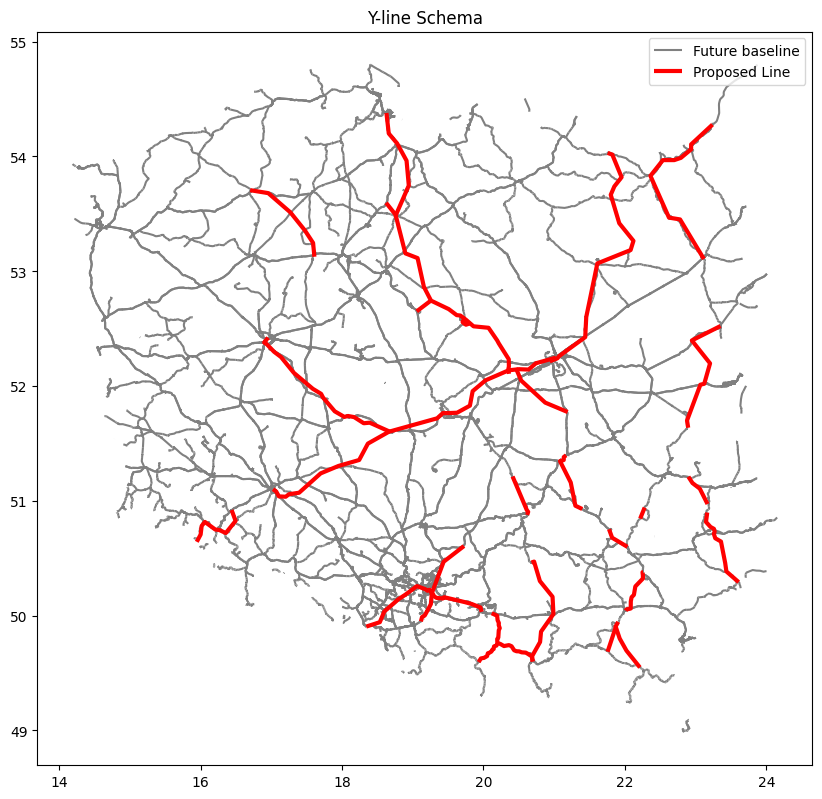

In [152]:
plot_two_geodataframes(gdf_future, gdf_y, title = "Y-line Scenario", file_name = root_fig_path + "y-line-schema.png")
plot_two_geodataframes(gdf_future, gdf_pis_project, title = 'PiS "Spokes" Scenario', file_name = root_fig_path + "ko-schema.png")
plot_two_geodataframes(gdf_future, gdf_ko_project, title = "KO Scenario", file_name = root_fig_path + "pis-spokes-schema.png")

# 1.1. Creating Highway Shapefiles

### 1.1.1. Existent Highways

In [15]:
def fill_maxspeed(df):
    """
    This function sets the “maxspeed” tag according to the default rooting settings for Poland from the OSM Wiki on the basis of the road type.
    https://wiki.openstreetmap.org/wiki/OSM_tags_for_routing/Maxspeed#Poland

    It doesn't differentiate between urbanized and non-urbanized area and sets the speed limit to 90 km/h also in urbanized areas.
    """
    
    df.loc[df["maxspeed"].isna() & (df["highway"] == "motorway"), "maxspeed"] = 140
    df.loc[df["maxspeed"].isna() & (df["highway"] == "trunk") & (df["oneway"] == "yes"), "maxspeed"] = 120
    df.loc[df["maxspeed"].isna() & (df["highway"] == "trunk") & (df["oneway"] != "yes"), "maxspeed"] = 100
    df.loc[df["maxspeed"].isna() & (df["highway"] == "motorway"), "maxspeed"] = 140
    df.loc[df["maxspeed"].isna() & (~df["highway"].isin(["motorway", "trunk"])) & (df["oneway"] == "yes"), "maxspeed"] = 100
    df.loc[df["maxspeed"].isna() & (~df["highway"].isin(["motorway", "trunk"])) & (df["oneway"] != "yes"), "maxspeed"] = 90
    return df

In [22]:
# For preliminary exploration, it is useful to decrease the filze size of the GeoJSON by dropping the redundant columns:
# gdf = prepare_shapefile(root_path + file + ".geojson")
# gdf = gdf[["osm_id", "highway", "other_tags", "geometry"]]
# gdf.to_file(root_path + file + ".geojson")

In [9]:
existent_highway_files = ["poland-highway-roads-220101", "poland-highway-roads-latest"]

for file in existent_highway_files:
    gdf = prepare_shapefile(root_path + file + ".geojson", extracted_tags = ["maxspeed", "oneway"])
    gdf = fill_maxspeed(gdf)
    gdf = gdf[["osm_id", "highway", "geometry", "maxspeed"]]
    gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')

Skipped 0 in total.
Skipped 0 in total.


### 1.1.2. Proposed Highways

In [83]:
proposed_highway_files = ["poland-highway-proposed-220101", "poland-highway-proposed-latest"]
for file in proposed_highway_files:
    gdf = prepare_shapefile(root_path + file + ".geojson", extracted_tags = ["maxspeed", "oneway", "proposed", "construction"])
    gdf = gdf[~(gdf["proposed"].isna()&gdf["construction"].isna()&gdf["maxspeed"].isna()&gdf["oneway"].isna())]
    gdf['highway'] = gdf['proposed']
    gdf['highway'] = gdf['highway'].fillna(gdf['construction'])
    gdf = fill_maxspeed(gdf)
    gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')

Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.


C:\Users\janek\AppData\Local\Temp\ipykernel_20344\1718068003.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')


Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.


C:\Users\janek\AppData\Local\Temp\ipykernel_20344\1718068003.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')


### 1.1.3. Highways under Construction

In [109]:
construction_highway_files = ["poland-highway-construction-220101", "poland-highway-construction-latest"]
for file in construction_highway_files:
    gdf = prepare_shapefile(root_path + file + ".geojson", extracted_tags = ["maxspeed", "construction", "oneway"])
    gdf = gdf[~(gdf["maxspeed"].isna()&gdf["construction"].isna()&gdf["oneway"].isna())]
    gdf = fill_maxspeed(gdf)
    gdf = gdf[["osm_id", "highway", "geometry", "maxspeed"]]
    gdf.to_file(root_path + file + ".shp", driver='ESRI Shapefile')

Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.
Skipped 0 in total.


### 1.1.4. Create Future Highways

In [110]:
# Load the latest, latest-proposed, and latest-construction shapefiles and merge them into one future shapefile.
gdf_roads = gpd.read_file(root_path + "poland-highway-roads-latest.shp")
gdf_proposed = gpd.read_file(root_path + "poland-highway-proposed-latest.shp")
gdf_construction = gpd.read_file(root_path + "poland-highway-construction-latest.shp")

In [111]:
# Merge the GeoDataFrames
gdf_future = gpd.GeoDataFrame(pd.concat([gdf_roads, gdf_proposed, gdf_construction], ignore_index=True))

In [113]:
gdf_future.to_file(root_path + "poland-highway-future.shp")

In [114]:
gdf_future

osm_id       highway maxspeed  \
0          2954556      tertiary       50   
1          4209388      tertiary       40   
2          4209391     secondary       90   
3          4209392     secondary       50   
4          4214349     secondary       90   
...            ...           ...      ...   
448064  1308301489  construction      100   
448065  1308301490  construction      100   
448066  1308302871  construction      100   
448067  1308302872  construction       90   
448068  1308302873  construction       90   

                                                 geometry name waterway  \
0       LINESTRING (20.03607 50.07940, 20.03613 50.079...  NaN      NaN   
1       LINESTRING (18.43994 54.06871, 18.43990 54.068...  NaN      NaN   
2       LINESTRING (18.27481 54.07826, 18.26480 54.084...  NaN      NaN   
3       LINESTRING (18.20281 54.13310, 18.20275 54.133...  NaN      NaN   
4       LINESTRING (18.20027 54.13288, 18.19934 54.132...  NaN      NaN   
...                                                   ...  ...      ...   
448064  LINESTRING (19.13100 50.05364, 19.13125 50.053...  NaN      NaN   
448065  LINESTRING (19.14804 50.07718, 19.14802 50.076...  NaN      NaN   
448066  LINESTRING (21.05393 51.06979, 21.05395 51.069...  NaN      NaN   
448067  LINESTRING (21.05375 51.07044, 21.05380 51.07030)  NaN      NaN   
448068  LINESTRING (21.05339 51.07003, 21.05320 51.06998)  NaN      NaN   

       aerialway barrier man_made railway  z_order other_tags oneway proposed  \
0            NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
1            NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
2            NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
3            NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
4            NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
...          ...     ...      ...     ...      ...        ...    ...      ...   
448064       NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
448065       NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
448066       NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
448067       NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   
448068       NaN     NaN      NaN     NaN      NaN        NaN    NaN      NaN   

       constructi  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
448064        NaN  
448065        NaN  
448066        NaN  
448067        NaN  
448068        NaN  

[448069 rows x 15 columns]

# 2. Computing Transport Matrix

***The whole section 2 has to be executed for every shapefile in the next cell below. For high control over every processing step, it is beneficial to execute the processing step after step in this Jupyter Notebook.***

Alternatively, I supply python code that does all the steps in a pipeline in one go.

In [26]:
# Set default speed to fill in where maxspeed value is not there
railway_speed = 90
road_speed = 56

file_name, write_file, default_speed = "poland-railway-rail-220101", "travel-time-matrix-2021-railway", railway_speed
#file_name, write_file, default_speed = "poland-railway-future", "travel-time-matrix-future-railway", railway_speed
#file_name, write_file, default_speed = "poland-railway-future_counterfactual", "travel-time-matrix-future-railway-counterfactual", railway_speed
#file_name, write_file, default_speed = "poland-railway-future_counterfactual2", "travel-time-matrix-future-railway-counterfactual2", railway_speed
#file_name, write_file, default_speed = "poland-railway-future_counterfactual3", "travel-time-matrix-future-railway-counterfactual3", railway_speed
#file_name, write_file, default_speed = "poland-highway-roads-220101", "travel-time-matrix-2021-highway", road_speed
#file_name, write_file, default_speed = "poland-highway-future", "travel-time-matrix-future-highway", road_speed

In [8]:
# Upload shapefiles
gdfCentroids = gpd.read_file(root_path + "powiaty_centroids.shp")
gdfNet = gpd.read_file(root_path + file_name + ".shp")

gdfCentroids = gdfCentroids.to_crs(epsg=3035)
gdfNet = gdfNet.to_crs(epsg=3035)
gdfNet["maxspeed"] = pd.to_numeric(gdfNet["maxspeed"], errors='coerce')
gdfNet.loc[gdfNet["maxspeed"].isna(), "maxspeed"] = default_speed
gdfNet.loc[gdfNet["maxspeed"]==0, "maxspeed"] = default_speed

#Check that it is the right reference system: https://epsg.io/?q=3035

<Axes: >

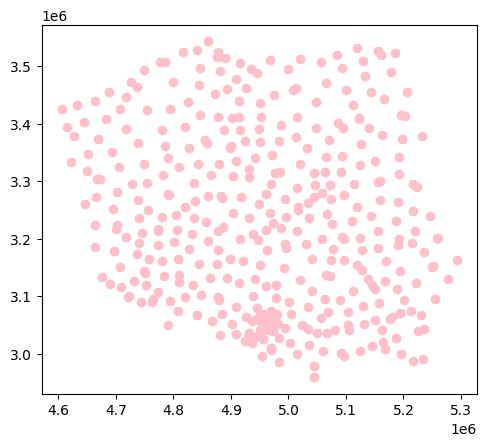

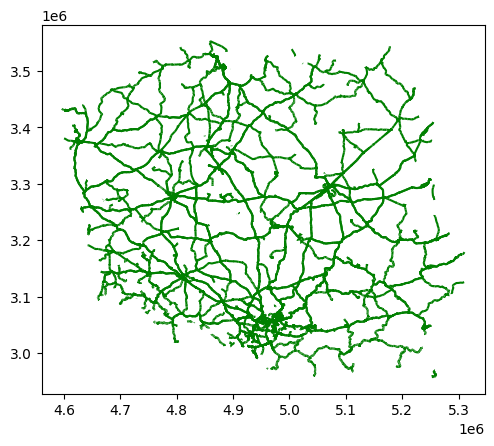

In [9]:
# Exploring the network #
gdfCentroids.plot(color='pink')
gdfNet.plot(color = 'green')

### 2.1. Preparing the network shapefile

In [10]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
from shapely.ops import unary_union

# Step 1: Prepare the transportation network shapefile for conversion into a Graph
n_segments_before_split = len(gdfNet)

# Fix geometries to avoid issues during graph conversion
unary = gdfNet.geometry.unary_union
gdfNet.geometry = gdfNet.geometry.buffer(0.01)  # Float arithmetic correction
geom = [i for i in unary.geoms]
id = [j for j in range(len(geom))]
unary = gpd.GeoDataFrame({'id': id, 'geometry': geom}, crs=3035)
gdfNet = gpd.sjoin(unary, gdfNet, how='inner', predicate='within')

n_segments_after_split = len(gdfNet)

print(f'Segments before split: {n_segments_before_split}.')
print(f'Segments after split: {n_segments_after_split}.')

# Step 2: Create a graph from the geometries
G = nx.Graph()

# Add edges to the graph based on the LineString geometries
for idx, geom in enumerate(gdfNet.geometry):
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], index=idx)

# Step 3: Identify the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Step 4: Filter the GeoDataFrame to keep only the geometries that are part of the largest connected component
def is_part_of_largest_cc(geom):
    coords = list(geom.coords)
    return any(coord in largest_cc for coord in coords)

gdfNet = gdfNet[gdfNet.geometry.apply(is_part_of_largest_cc)]

# Step 5: Assign travel time to each segment
gdfNet['travel_time'] = ((gdfNet.length / 1000) / gdfNet["maxspeed"].astype(float)) * 60

# Step 6: Assign unique IDs and clean the dataframe
gdfNet = gdfNet.reset_index(drop=True)
gdfNet = gdfNet.drop(columns=['index_right'])

print(f'Segments after filtering: {len(gdfNet)}.')

Segments before split: 64941.
Segments after split: 120850.
Segments after filtering: 116985.


<Axes: >

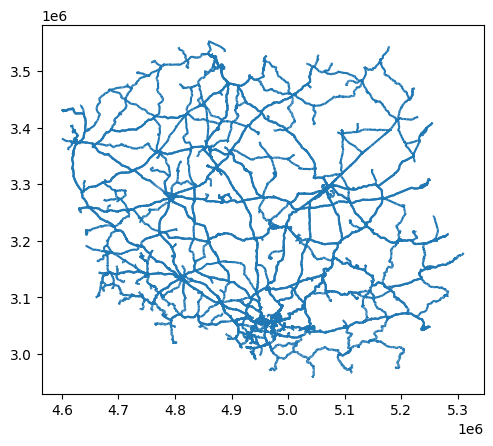

In [11]:
# Exploring the network
gdfNet.plot()

In [12]:
print(gdfNet.head())
print(gdfNet.describe())

   id                                           geometry   osm_id  maxspeed  \
0   0  LINESTRING (4969857.721 3225402.179, 4969832.2...  4692799        56   
1   1  LINESTRING (4969988.644 3225123.960, 4969986.8...  4692800        56   
2   2  LINESTRING (4969434.714 3226171.903, 4969423.8...  4692801       100   
3   3  LINESTRING (4970919.790 3231814.570, 4970892.9...  4692802       100   
4   4  LINESTRING (4962706.087 3236224.455, 4962681.6...  4692803       120   

   travel_time  
0     0.053107  
1     0.344013  
2     0.012682  
3     0.060880  
4     0.580673  
                  id       maxspeed    travel_time
count  116985.000000  116985.000000  116985.000000
mean    60465.749241      66.085532       0.338928
std     34925.258426      26.110802       0.988211
min         0.000000       5.000000       0.000070
25%     30187.000000      56.000000       0.043748
50%     60513.000000      56.000000       0.091275
75%     90787.000000      56.000000       0.329441
max    120792.0

### 2.2. Preparing centroids for conversion into Graph

In [13]:
from shapely.ops import nearest_points
from shapely.geometry import LineString

# Assume the entry points to the railway line are all geometry nodes in the line.
# It is a simplifying assumption.

entryPoints = []
for geom in gdfNet.geometry:
    if geom.geom_type == 'Point':
        entryPoints.append(geom)
    elif geom.geom_type in ['LineString', 'Polygon']:
        entryPoints.append(list(geom.coords)[0])
        entryPoints.append(list(geom.coords)[-1])
    else:
        print("None of the three types.")

print("Created entryPoints list.")

entryPoints = set(entryPoints)
gdfEntryPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([tpl[0] for tpl in entryPoints], [tpl[1] for tpl in entryPoints]), crs=3035)
powiaty_codes = list(gdfCentroids['JPT_KOD_JE'])

#Use geopandas's sjoin_nearest to find the closest street network vertice for each zonal centroid, then build straight lines.
mappingCentroidToNet = gpd.sjoin_nearest(gdfCentroids, gdfEntryPoints, how='left')['index_right'].to_dict()
lines = []
for centroid, entryPoint in mappingCentroidToNet.items():
  ptStart = gdfCentroids.loc[centroid, 'geometry']
  ptEnd = gdfEntryPoints.loc[entryPoint, 'geometry']
  line = LineString([ptStart, ptEnd])
  lines.append(line)

gdfConnections = gpd.GeoDataFrame(geometry=lines, crs=3035)

# I assume the travel time to the nearest railway access at pace of 30km/h
gdfConnections['travel_time'] = ((gdfConnections.length / 1000) / 30) * 60

Created entryPoints list.


<Axes: >

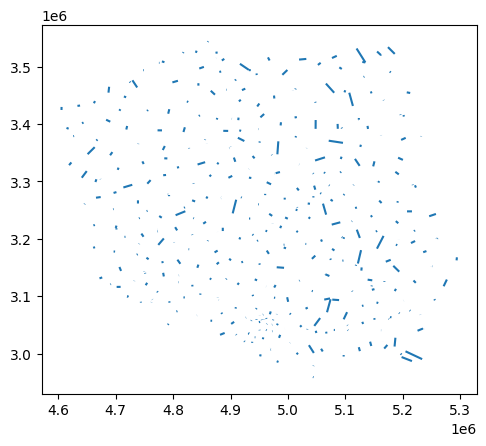

In [14]:
gdfConnections.plot()

In [15]:
print(gdfConnections.describe())

       travel_time
count   380.000000
mean      9.462192
std      10.551052
min       0.020075
25%       2.513630
50%       5.907866
75%      11.947185
max      64.034489


Plot saved to E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/python/railway_with_centroids_2021.png


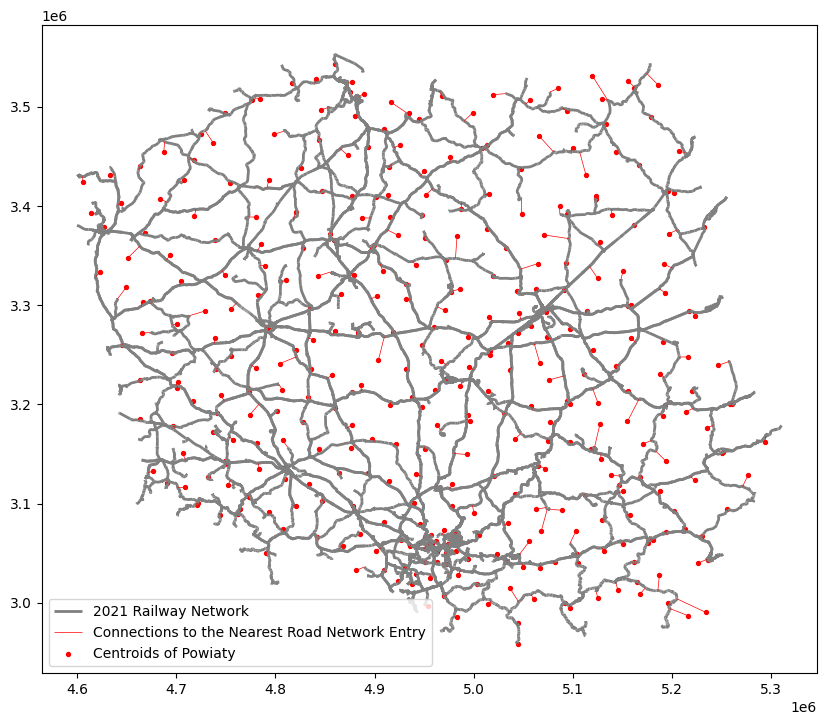

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_network_with_connections(gdfNet, gdfConnections, gdfCentroids, title='2021 Railway Network', file_name=None):
    """
    Plots the railway network, connections, and centroids of Powiaty.
    Optionally saves the plot to a file.
    
    Parameters:
    - gdfNet: GeoDataFrame of the railway network.
    - gdfConnections: GeoDataFrame of connections to the nearest railway.
    - gdfCentroids: GeoDataFrame of the centroids of Powiaty.
    - title: Title for the plot.
    - file_name: Optional file name to save the plot. If None, the plot is not saved.
    """
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the street network
    gdfNet.plot(ax=ax, color='grey', linewidth=2, label='2021 Railway Network')
    
    # Plot the connections
    gdfConnections.plot(ax=ax, color='red', linewidth=0.5, label='Connections to the Nearest Road Network Entry')
    
    # Add the centroids of Powiaty
    gdfCentroids.plot(ax=ax, color='red', marker='o', markersize=8, label='Centroids of Powiaty')
    
    # Set the title and legend
    #ax.set_title(title)
    ax.legend()
    
    # Save the plot to a file if file_name is provided
    if file_name:
        plt.savefig(file_name, format='png', bbox_inches='tight')
        print(f"Plot saved to {file_name}")
    
    # Show the plot
    plt.show()

plot_network_with_connections(gdfNet, gdfConnections, gdfCentroids, file_name = root_fig_path + "railway_with_centroids_2021.png")

### 2.3. Creating nx graph

In [17]:
# Step 1: Create a graph from the geometries
G = nx.Graph()

# Add edges to the graph based on the gdfNet LineString geometries
for idx, geom in enumerate(gdfNet.geometry):
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        G.add_edge(coords[0], coords[-1], index=idx, travel_time = gdfNet.loc[idx, 'travel_time'])

# Check if the graph G is connected
is_connected = nx.is_connected(G)

# Print the result
if is_connected:
    print("The graph G is connected.")
else:
    print("The graph G is not connected.")

# Step 2: Add edges to the graph based on the gdfConnections LineString geometries
for idx, geom in enumerate(gdfConnections.geometry):
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        
        # Add the centroid (starting point) as a vertex with a unique identifier
        centroid_vertex = coords[0]
        network_vertex = coords[-1]

        # Add the centroid vertex with a 'centroid_id' attribute
        G.add_node(centroid_vertex, centroid_id=powiaty_codes[idx])

        # Add the edge from the centroid to the network with 'travel_time' attribute
        G.add_edge(centroid_vertex, network_vertex, connection_idx=idx, travel_time=gdfConnections.loc[idx, 'travel_time'])

# Check if the graph G is connected
is_connected = nx.is_connected(G)

# Print the result
if is_connected:
    print("The graph G is connected.")
else:
    print("The graph G is not connected.")

The graph G is connected.
The graph G is connected.


In [18]:
print(f"Total number of graph edges: {len(G.edges())}")

Total number of graph edges: 115039


In [19]:
def check_edges_have_attribute(graph, attribute):
    for u, v, data in graph.edges(data=True):
        if attribute not in data:
            return False
    return True

# Check if all edges have "travel_time" attribute
if check_edges_have_attribute(G, "travel_time"):
    print("All edges have the 'travel_time' attribute.")
else:
    print("Not all edges have the 'travel_time' attribute.")

All edges have the 'travel_time' attribute.


In [20]:
import networkx as nx

def shortest_path_between_centroids(G, centroid_id_1, centroid_id_2):
    """
    Computes the shortest path between two centroids in the graph G and the total travel time.

    Parameters:
    - G: NetworkX graph where nodes corresponding to centroids have a 'centroid_id' attribute.
    - centroid_id_1: ID of the starting centroid.
    - centroid_id_2: ID of the destination centroid.

    Returns:
    - path: List of nodes representing the shortest path.
    - total_travel_time: Total travel time for the shortest path in minutes.
    """
    
    # Find the nodes in the graph corresponding to the centroid IDs
    start_node = None
    end_node = None
    
    for node, data in G.nodes(data=True):
        if data.get('centroid_id') == centroid_id_1:
            start_node = node
        elif data.get('centroid_id') == centroid_id_2:
            end_node = node
    
    if start_node is None or end_node is None:
        raise ValueError("One or both of the centroid IDs do not exist in the graph.")
    
    # Compute the shortest path between the two nodes
    path = nx.shortest_path(G, source=start_node, target=end_node, weight='travel_time')
    
    # Compute the total travel time for the path
    total_travel_time = sum(G[u][v].get('travel_time', 0) for u, v in zip(path[:-1], path[1:]))
    
    return path, total_travel_time

# Example usage
# path, travel_time = shortest_path_between_centroids(G, centroid_id_1=powiaty_codes[10], centroid_id_2=powiaty_codes[14])


In [27]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import geopandas as gpd

def plot_shortest_path(G, path, travel_time, gdfNet, file_name=None, ax=None):
    """
    Plots the shortest path on the same plot as the gdfNet and adds the travel time to the legend.
    Optionally saves the plot to a file.
    
    Parameters:
    - G: NetworkX graph where nodes corresponding to centroids have a 'centroid_id' attribute.
    - path: List of nodes representing the shortest path.
    - travel_time: Total travel time for the shortest path in minutes.
    - gdfNet: GeoDataFrame of the railway network.
    - file_name: Optional file name to save the plot. If None, the plot is not saved.
    - ax: Matplotlib axis to plot on. If None, a new figure and axis will be created.
    """
    
    # Create a LineString from the path nodes
    path_coords = [node for node in path]
    path_line = LineString(path_coords)
    
    # Convert the LineString to a GeoDataFrame for easy plotting
    gdfPath = gpd.GeoDataFrame(geometry=[path_line], crs=gdfNet.crs)
    
    # Plot the railway network (gdfNet) if an axis is not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.figure
    
    # Plot the railway network
    gdfNet.plot(ax=ax, color='grey', linewidth=2, label='2021 Railway Network')
    
    # Plot the shortest path
    gdfPath.plot(ax=ax, color='red', linewidth=3, linestyle='--', label=f'Shortest Path (Travel Time: {travel_time:.2f} min)')
    
    # Add a legend
    ax.legend()
    
    # Save the plot to a file if file_name is provided
    if file_name:
        plt.savefig(file_name, format='png', bbox_inches='tight')
        print(f"Plot saved to {file_name}")
    
    # Show the plot
    plt.show()

Plot saved to E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/python/example_railway_shortest_path_2021.png


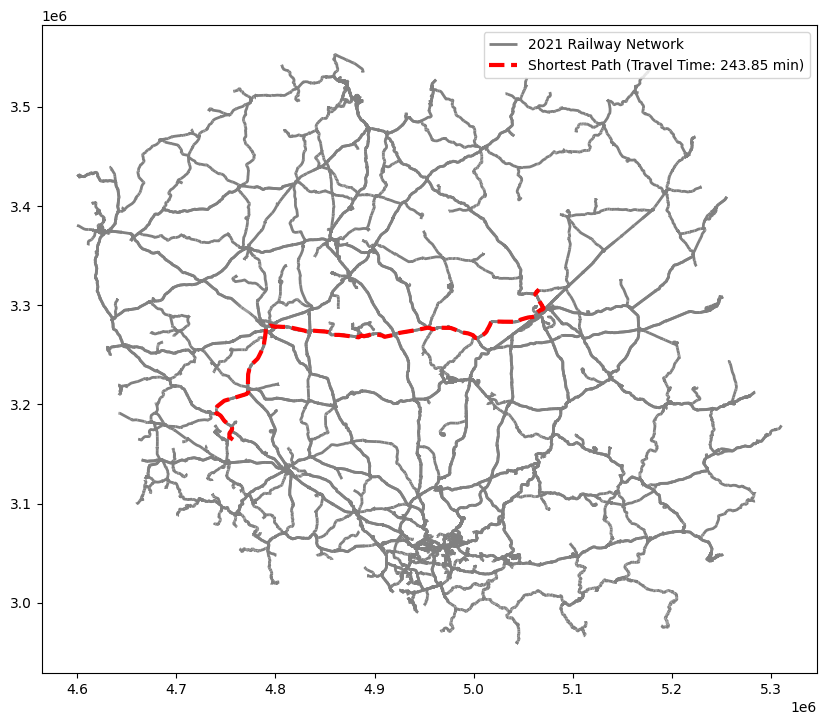

In [21]:
# Generate an example shortest path to check if the paths are correctly computed
# Compute the shortest path between two centroid IDs
path, travel_time = shortest_path_between_centroids(G, centroid_id_1=powiaty_codes[10], centroid_id_2=powiaty_codes[144])

# Plot the shortest path along with the railway network and display travel time
plot_shortest_path(G, path, travel_time, gdfNet, file_name = root_fig_path + "example_railway_shortest_path_2021.png")

### 2.4. Computing travel time matrix

In [22]:
import numpy as np
import networkx as nx

def compute_travel_time_matrix(G, set_1, set_2):
    """
    Computes a travel time matrix between two sets of points based on the shortest path in the graph G.

    Parameters:
    - G: NetworkX graph where edges have a 'travel_time' attribute.
    - set_1: List of centroid IDs corresponding to the first set of points.
    - set_2: List of centroid IDs corresponding to the second set of points.

    Returns:
    - travel_time_matrix: A 2D NumPy array where each element (i, j) is the travel time from set_1[i] to set_2[j].
    """
    
    # Extract the nodes corresponding to centroid IDs in set_1 and set_2
    nodes_set_1 = [next(node for node, data in G.nodes(data=True) if data.get('centroid_id') == cid) for cid in set_1]
    nodes_set_2 = [next(node for node, data in G.nodes(data=True) if data.get('centroid_id') == cid) for cid in set_2]
    
    # Initialize the travel time matrix
    travel_time_matrix = np.full((len(set_1), len(set_2)), np.inf)  # Fill with infinity as default
    
    # Compute shortest paths from all nodes in set_1 to all nodes in set_2
    for i, node_start in enumerate(nodes_set_1):
        print(f"Batch {i} out of {len(nodes_set_1)}.")
        lengths = nx.single_source_dijkstra_path_length(G, source=node_start, weight='travel_time')
        for j, node_end in enumerate(nodes_set_2):
            travel_time_matrix[i, j] = lengths.get(node_end, np.inf)  # Default to infinity if no path exists
    
    return travel_time_matrix

In [23]:
travel_time_matrix = compute_travel_time_matrix(G, powiaty_codes, powiaty_codes)

Batch 0 out of 380.
Batch 1 out of 380.
Batch 2 out of 380.
Batch 3 out of 380.
Batch 4 out of 380.
Batch 5 out of 380.
Batch 6 out of 380.
Batch 7 out of 380.
Batch 8 out of 380.
Batch 9 out of 380.
Batch 10 out of 380.
Batch 11 out of 380.
Batch 12 out of 380.
Batch 13 out of 380.
Batch 14 out of 380.
Batch 15 out of 380.
Batch 16 out of 380.
Batch 17 out of 380.
Batch 18 out of 380.
Batch 19 out of 380.
Batch 20 out of 380.
Batch 21 out of 380.
Batch 22 out of 380.
Batch 23 out of 380.
Batch 24 out of 380.
Batch 25 out of 380.
Batch 26 out of 380.
Batch 27 out of 380.
Batch 28 out of 380.
Batch 29 out of 380.
Batch 30 out of 380.
Batch 31 out of 380.
Batch 32 out of 380.
Batch 33 out of 380.
Batch 34 out of 380.
Batch 35 out of 380.
Batch 36 out of 380.
Batch 37 out of 380.
Batch 38 out of 380.
Batch 39 out of 380.
Batch 40 out of 380.
Batch 41 out of 380.
Batch 42 out of 380.
Batch 43 out of 380.
Batch 44 out of 380.
Batch 45 out of 380.
Batch 46 out of 380.
Batch 47 out of 380.
Ba

In [74]:
#import numpy as np
#csv_path = r"E:\Studia\Studia magisterskie\Wirtschaftwissenschaft\Quantitative Spatial Economics\Central-Communication-Port-Appraisal\data\input\travel-time-matrix-future-railway-counterfactual3.csv"
#travel_time_matrix = np.genfromtxt(csv_path, delimiter=',')

In [24]:
travel_time_matrix

array([[  0.        , 117.74971498,  68.51410558, ..., 283.61328994,
        206.58370163, 258.93672422],
       [117.74971498,   0.        , 117.13527865, ..., 283.12154101,
        236.98750652, 281.45686983],
       [ 68.51410558, 117.13527865,   0.        , ..., 219.36440935,
        141.11338355, 193.46640614],
       ...,
       [283.61328994, 283.12154101, 219.36440935, ...,   0.        ,
        100.180389  , 144.64975232],
       [206.58370163, 236.98750652, 141.11338355, ..., 100.180389  ,
          0.        ,  74.27719562],
       [258.93672422, 281.45686983, 193.46640614, ..., 144.64975232,
         74.27719562,   0.        ]])

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

def color_counties(shapefile_path, color_values, color_scheme = 'green', railway_gdf=None, write_path=None):
    """
    Colors the counties in Poland according to the numbers passed in the list.

    Parameters:
    - shapefile_path: Path to the shapefile containing the administrative borders of counties.
    - color_values: List of numbers used to color the counties. The order should match the order of the counties in the shapefile.
    """
    # Load the shapefile using GeoPandas
    gdf = gpd.read_file(shapefile_path)
    
    # Ensure the color_values list is the same alength as the number of counties
    if len(color_values) != len(gdf):
        raise ValueError("The length of the color_values list must match the number of counties in the shapefile.")
    
    # Add the color values to the GeoDataFrame
    gdf['color_value'] = color_values

    # Set the colormap
    if color_scheme == 'green':
        cmap = plt.cm.viridis  # Use green colormap
    elif color_scheme == 'grey':
        cmap = plt.colormaps['Greys']   # Use gray colormap
    else:
        raise ValueError("Invalid color_scheme. Choose 'gray' or 'green'.")
    
    # Normalize the color values to a colormap range
    norm = plt.Normalize(vmin=min(color_values), vmax=max(color_values))
    
    # Plot the counties with the assigned colors
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='color_value', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')

    # Add the railway line if provided
    if railway_gdf is not None:
        railway_gdf.plot(ax=ax, color='red', linewidth=1, linestyle='-', edgecolor='none')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)
    
    # Set title and show plot
    plt.title("Poland: Counties (Powiaty) Colored by Distance from a Chosen Origin")
    
    # Save or show plot
    if write_path:
        plt.savefig(write_path, bbox_inches='tight')
        print(f"Plot saved to {write_path}")
    else:
        plt.show()

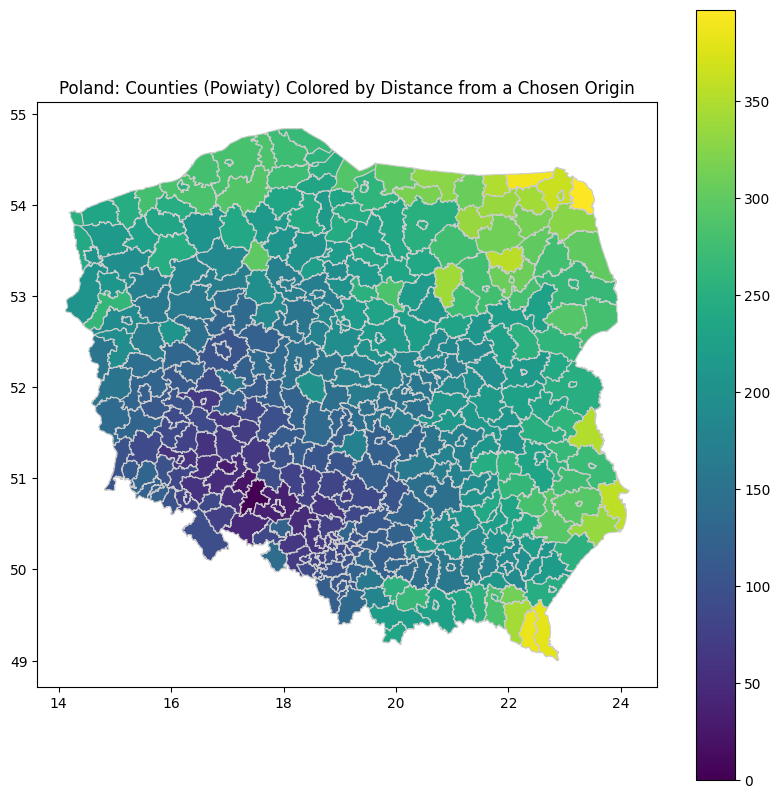

In [25]:
# Plot shortest distances from an example county to check if the paths are correctly computed
color_values = travel_time_matrix[179, :]
color_counties(root_path + 'powiaty.shp', color_values, color_scheme = 'green')

In [58]:
import pandas as pd

# Commented to prevent accidental execution ;) Please, uncomment.
# np.savetxt(data_input_path + write_file + '.csv', travel_time_matrix, delimiter=',')
print("Travel time matrix has been saved to file.")

Travel time matrix has been saved to file.


# 3. Plot the outcomes

***This section should be executed after full execution of the matlab code that generater the model predictions***

In [94]:
gdf_y = gpd.read_file(root_path + "poland-railway-proposed-latest-y.shp")
gdf_pis_project = gpd.read_file(root_path + "poland-railways-proposed-pis.shp")
gdf_ko_project = gpd.read_file(root_path + "KO.shp")
scenarios = [gdf_y, gdf_pis_project, gdf_ko_project]

E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/data/output/ctf1_rChange.csv
E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/ctf1_rChange.png
Plot saved to E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/ctf1_rChange.png
E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/data/output/ctf1_vChange.csv
E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/ctf1_vChange.png
Plot saved to E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/ctf1_vChange.png
E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communic

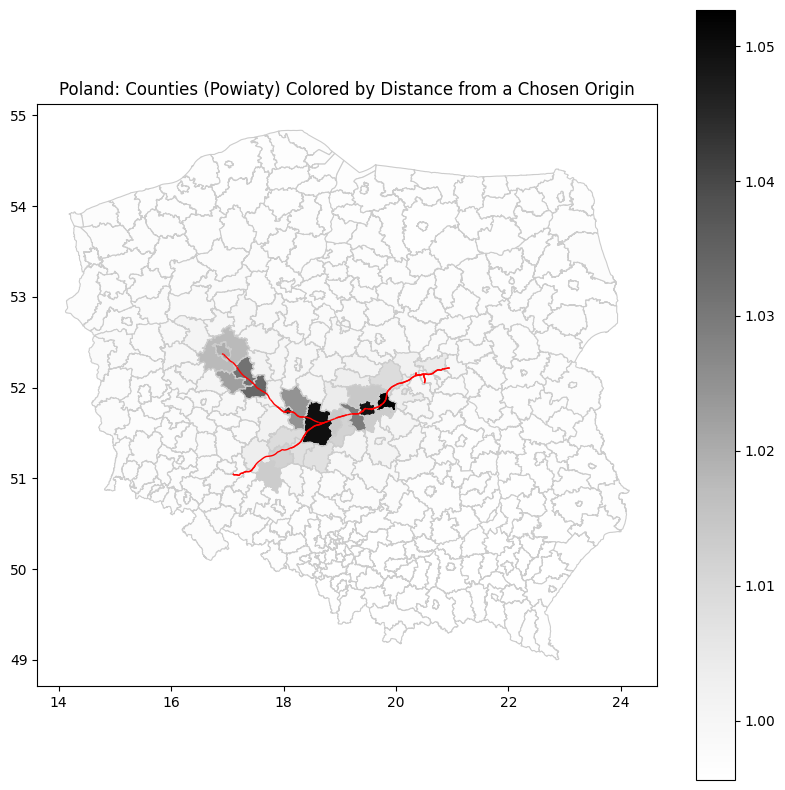

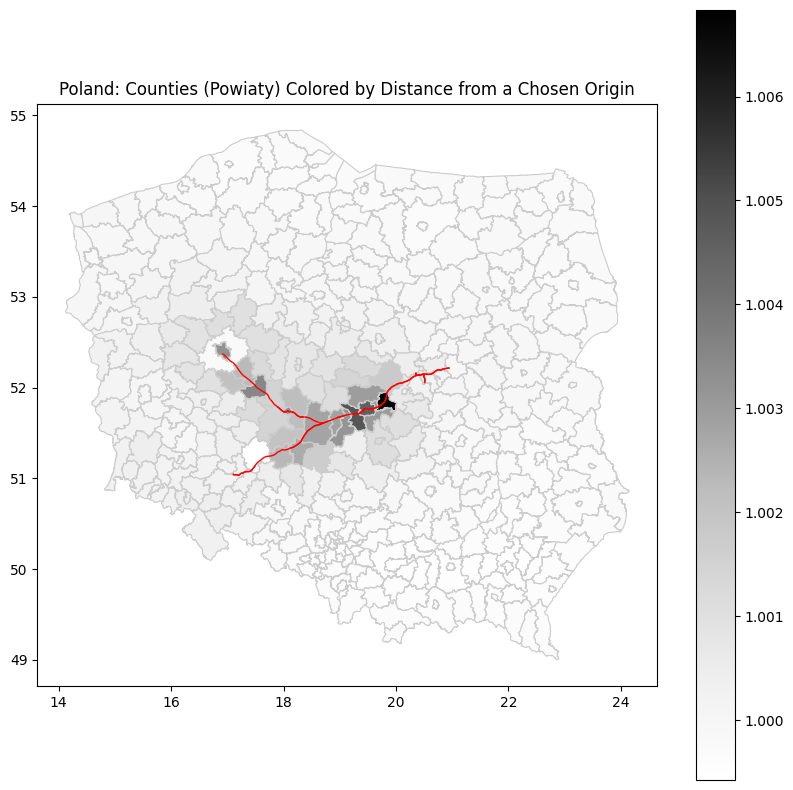

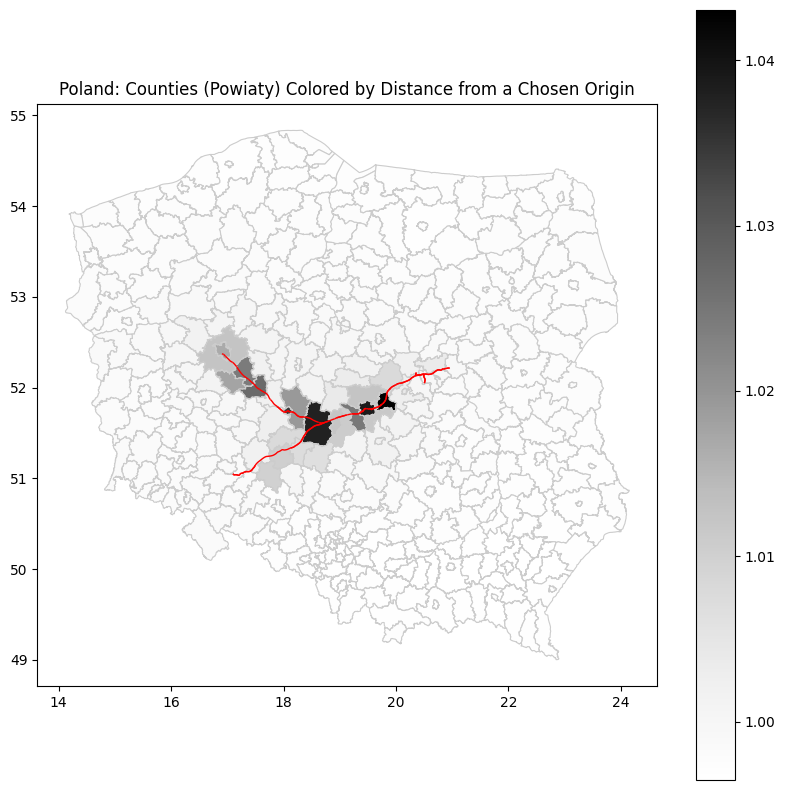

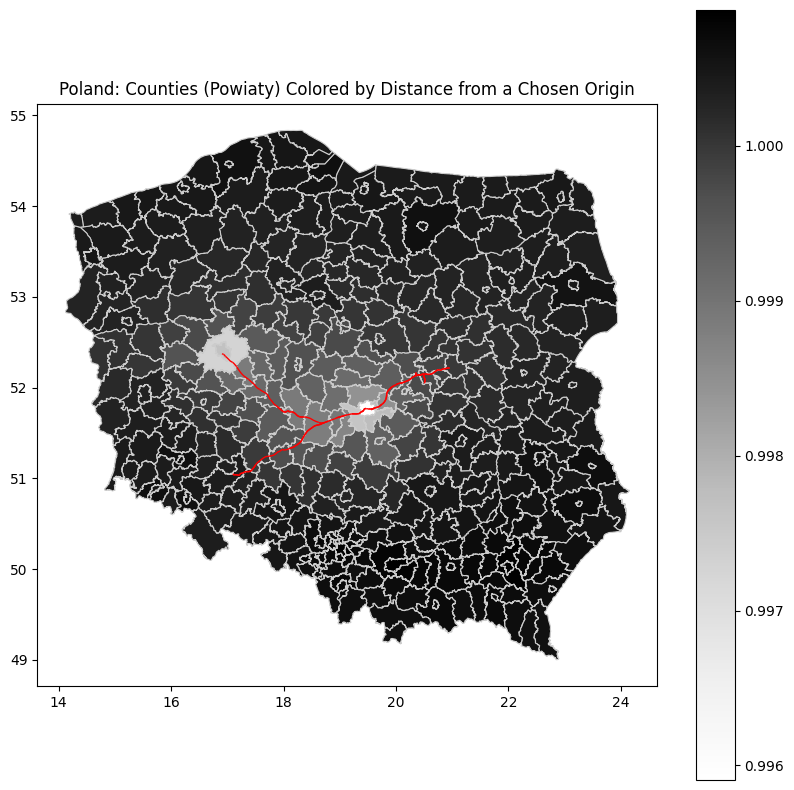

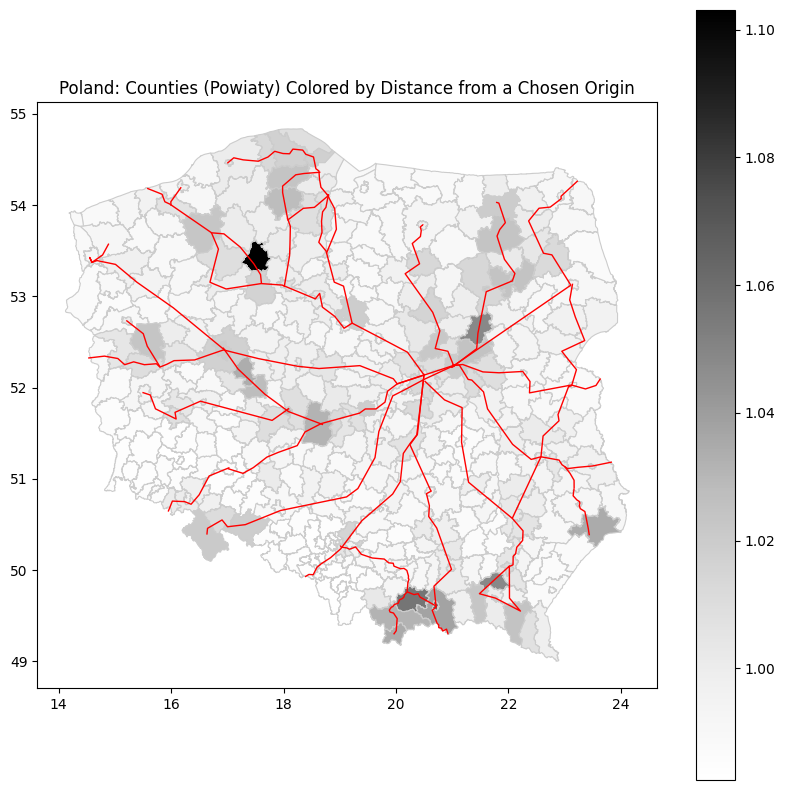

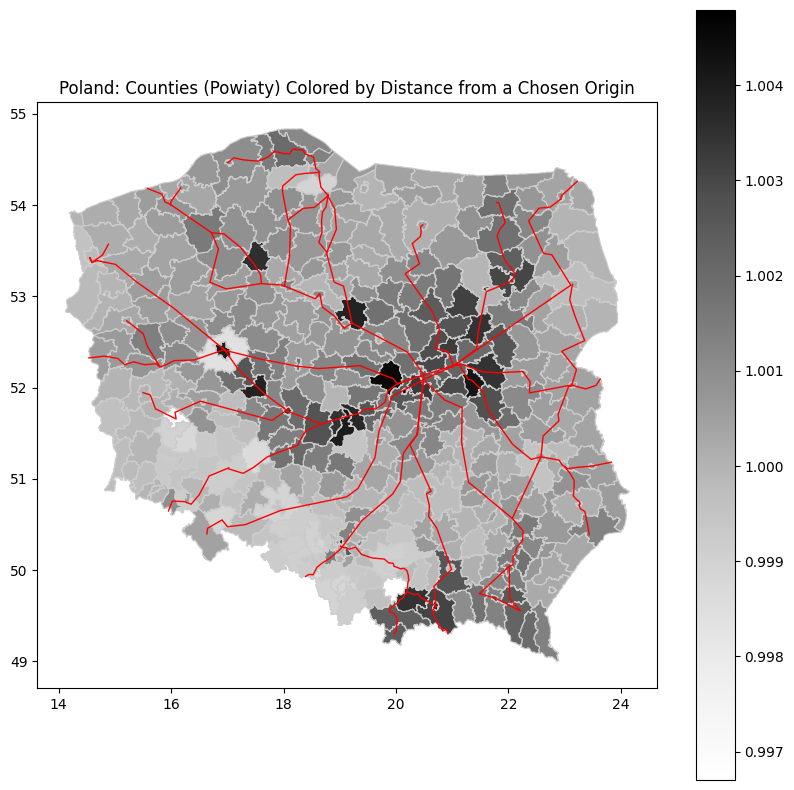

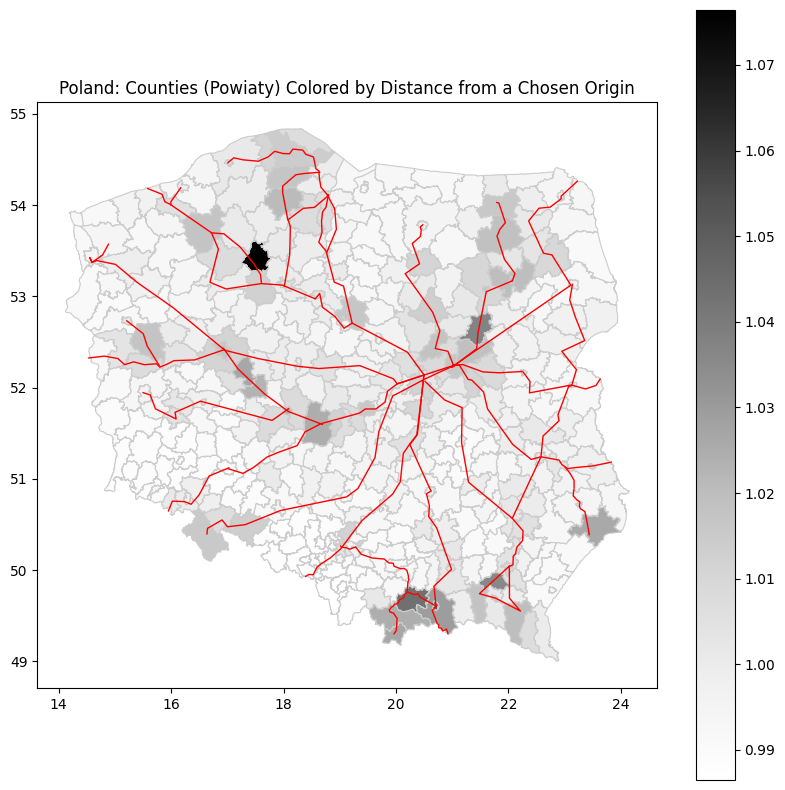

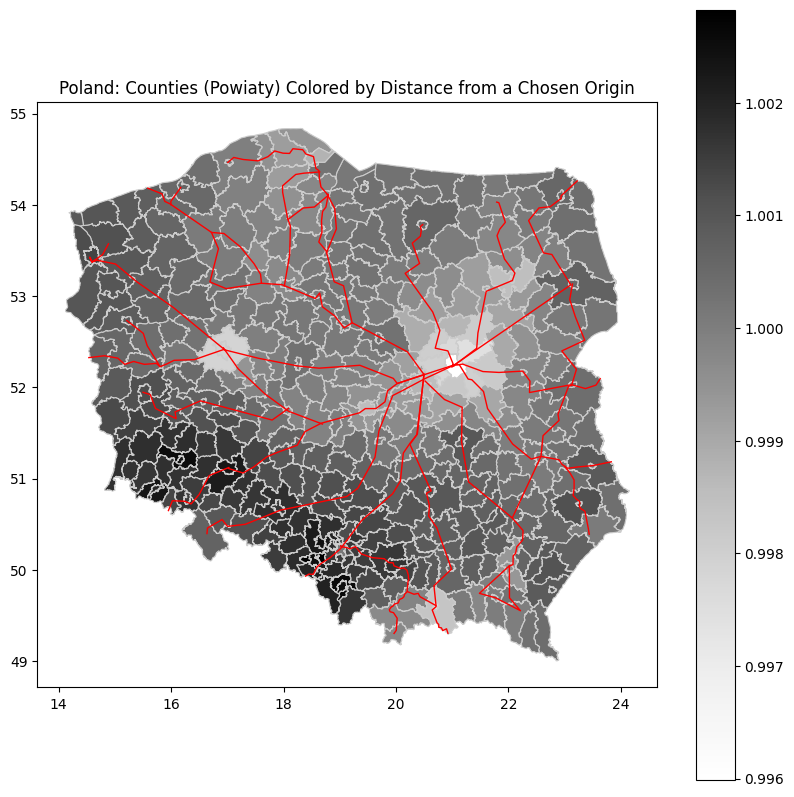

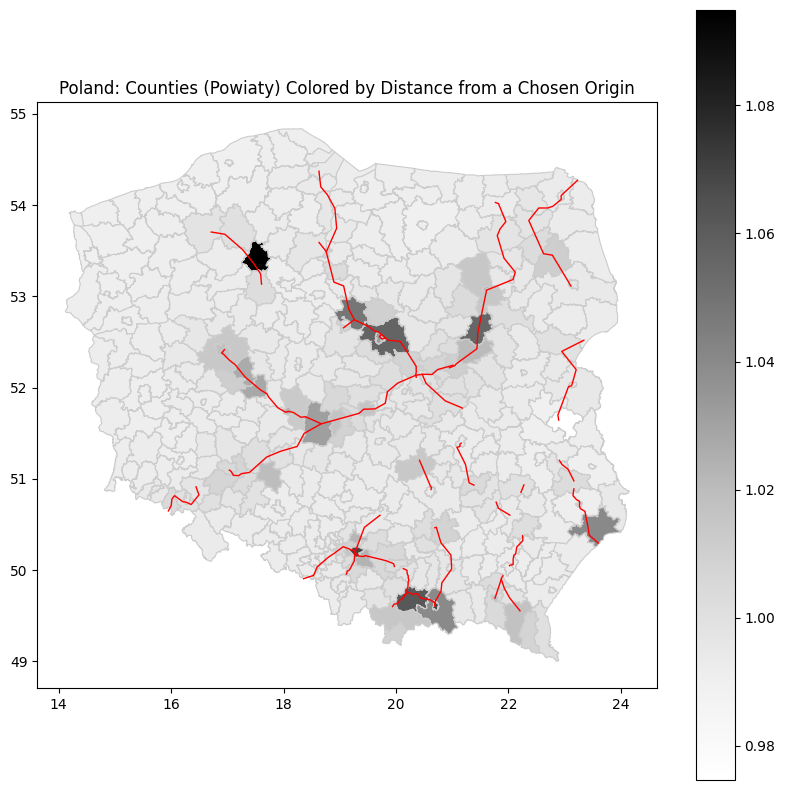

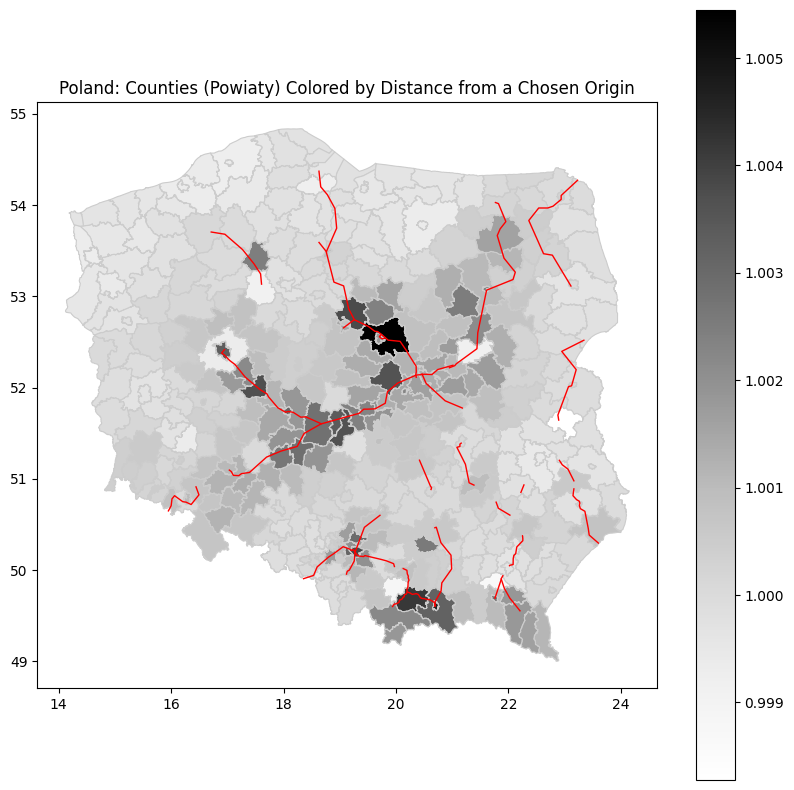

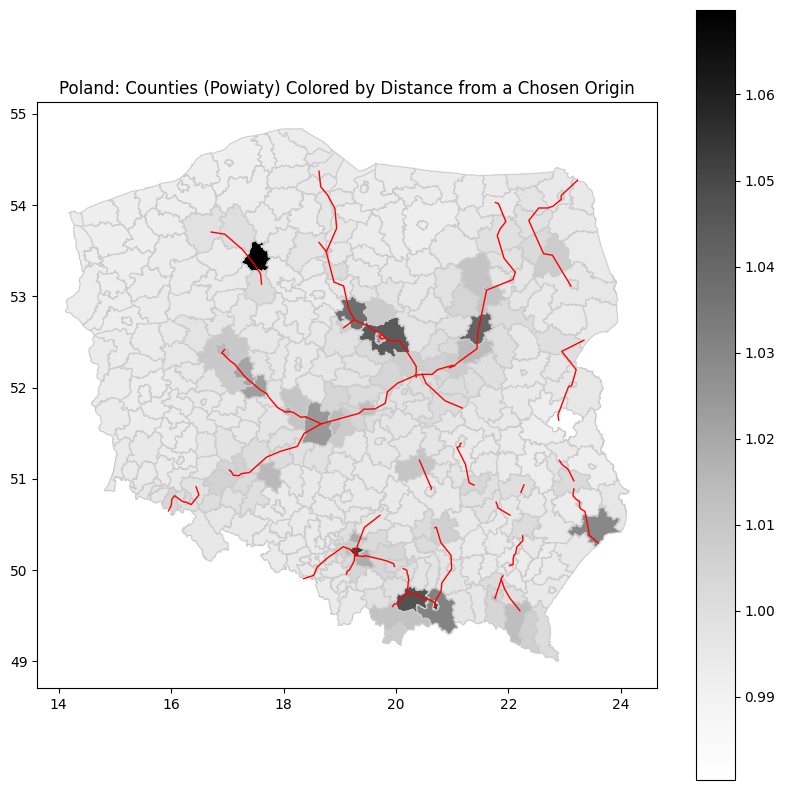

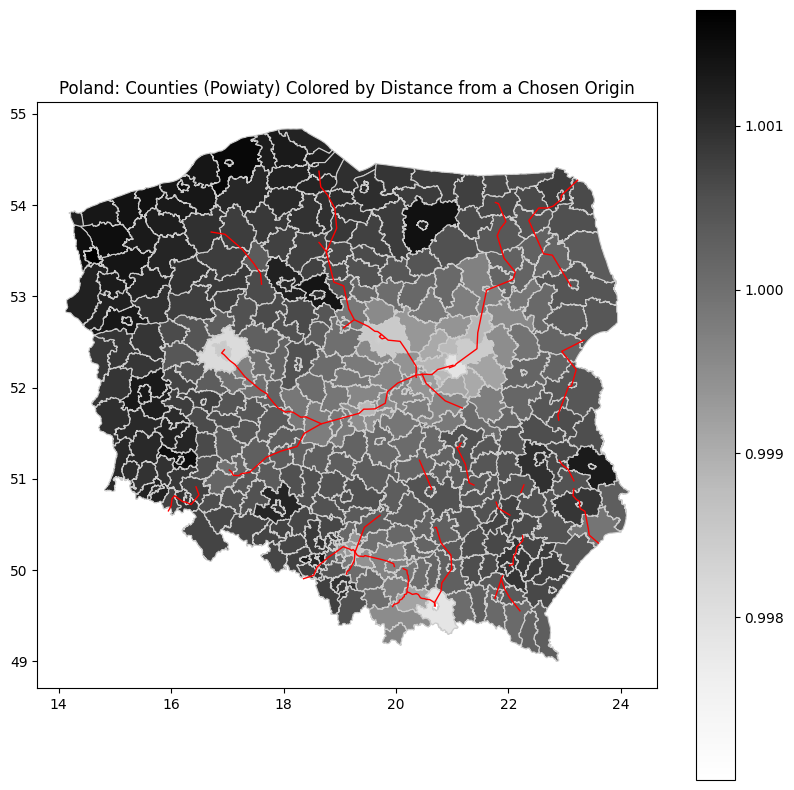

In [102]:
plots = ["rChange", "vChange", "qChange", "pChange"]
csv_root = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/data/output/"
powiaty_path = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/shape/powiaty.shp"
railway_root = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/shape/"
write_root = "E:/Studia/Studia magisterskie/Wirtschaftwissenschaft/Quantitative Spatial Economics/Central-Communication-Port-Appraisal/figs/"

for i, scenario in enumerate(scenarios):
    for plot in plots:
        # Load the CSV data
        csv_path = csv_root + "ctf" + str(i+1) + "_" + plot + ".csv"
        csv_data = pd.read_csv(csv_path, names = ["change"], header = None)
        
        write_path = write_root + "ctf" + str(i+1) + "_" + plot + ".png"
        print(csv_path)
        print(write_path)
        color_counties(powiaty_path, list(csv_data.change), color_scheme = 'grey', railway_gdf = scenario, write_path = write_path)